# Trading Strategies with Token Metrics AI API

This notebook demonstrates how to implement trading strategies using the data from Token Metrics AI API. We'll implement two strategies:

1. **ETH Breakout Strategy** - A strategy that buys ETH when it breaks above its 30-day high
2. **Market Cap Weighted Portfolio** - A strategy that builds a portfolio of the top 10 tokens by market cap

Note: For backtesting, we'll use VectorBT, a powerful library for backtesting trading strategies.

## Setup

Let's install the required packages:

In [1]:
# Uncomment to install packages
# !pip install tmai-api pandas vectorbt matplotlib
#!pip list

Import the necessary libraries:

In [2]:
from tmai_api import TokenMetricsClient
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set Matplotlib parameters
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 8)

# Initialize the client
client = TokenMetricsClient(api_key="YOUR-API-KEY")

## Strategy 1: ETH Breakout Strategy

This strategy buys ETH when it breaks above its 30-day high and sells after 3 days.

### Step 1: Fetch ETH Daily Price Data

We'll use the `daily_ohlcv` endpoint to get Ethereum's price data for the last year.

In [3]:
# Calculate date range for the last year
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=365*4)).strftime("%Y-%m-%d")

# Fetch ETH daily OHLCV data
# Using token_id=3306 for Ethereum as recommended in the strategy
eth_ohlcv_df = client.daily_ohlcv.get_dataframe(
    token_id="3306",
    startDate=start_date,
    endDate=end_date
)

# Display the data
eth_ohlcv_df.head(16)

Fetching daily-ohlcv data: 100%|██████████| 51/51 [00:32<00:00,  1.55chunk/s]


,TOKEN_ID,TOKEN_NAME,TOKEN_SYMBOL,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME
0,3306,Ethereum,ETH,2021-05-02T00:00:00.000Z,2944.827239,2989.00,2854.180000,2950.337798,1.388496e+08
1,3306,Ethereum,ETH,2021-05-01T00:00:00.000Z,2772.968933,2958.00,2743.410000,2945.032767,1.751097e+08
2,3306,Ethereum,ETH,2021-04-30T00:00:00.000Z,2756.431215,2802.06,2721.090000,2773.212519,1.875711e+08
3,3306,Ethereum,ETH,2021-04-29T00:00:00.000Z,2745.975170,2801.70,2660.760000,2757.638455,2.050789e+08
4,3306,Ethereum,ETH,2021-04-28T00:00:00.000Z,2668.874335,2763.75,2518.530000,2745.129524,2.089989e+08
5,3306,Ethereum,ETH,2021-04-27T00:00:00.000Z,2530.434973,2683.65,2479.300000,2663.693422,1.974399e+08
6,3306,Ethereum,ETH,2021-04-26T00:00:00.000Z,2399.018313,2549.10,2382.590482,2533.783259,1.678320e+08
7,3306,Ethereum,ETH,2021-04-25T00:00:00.000Z,2217.930064,2360.20,2135.660000,2318.560866,2.669848e+08
8,3306,Ethereum,ETH,2021-04-24T00:00:00.000Z,2339.942282,2369.52,2154.160000,2216.943935,2.119326e+08
9,3306,Ethereum,ETH,2021-04-23T00:00:00.000Z,2395.314444,2444.89,2040.000000,2362.995330,1.547148e+08


### Step 2: Prepare Data for the Strategy

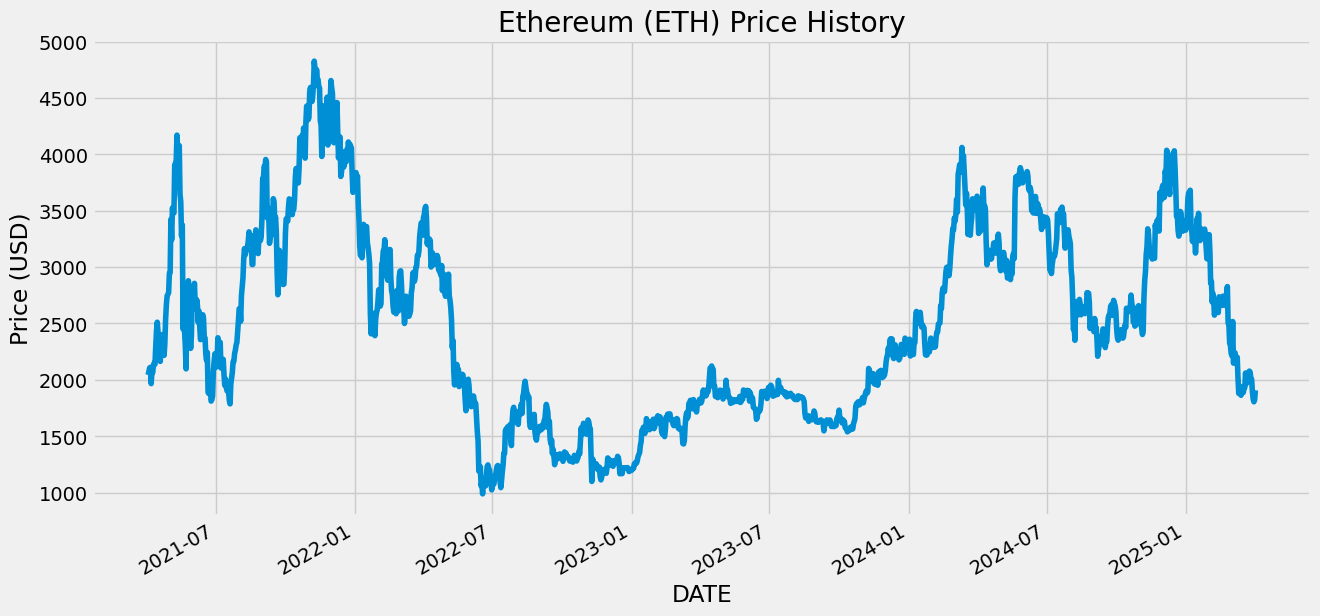

In [4]:
# Filter for Ethereum data only and sort by date
eth_data = eth_ohlcv_df[eth_ohlcv_df['TOKEN_ID'] == 3306].copy()
eth_data['DATE'] = pd.to_datetime(eth_data['DATE'])
eth_data = eth_data.sort_values('DATE')

# Extract closing price and set index to timestamp
eth_price = eth_data.set_index('DATE')['CLOSE']

# Plot ETH price
plt.figure(figsize=(14, 7))
eth_price.plot(title="Ethereum (ETH) Price History")
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

### Step 3: Implement the ETH Breakout Strategy

In [5]:
# Compute 30-day high (shifted by 1 day to avoid look-ahead bias)
rollmax = eth_price.rolling(30).max().shift(1)

# Define entry signals: price breaks above 30-day high
entries = eth_price > rollmax

# Define exit signals: sell 3 days after entry
exits = entries.shift(3).fillna(False)

# Display first few signals
pd.DataFrame({
    'Price': eth_price,
    '30-Day High': rollmax,
    'Entry Signal': entries,
    'Exit Signal': exits
}).head(10)

,Price,30-Day High,Entry Signal,Exit Signal
DATE,,,,
2021-04-03 00:00:00+00:00,2043.403389,NaN,False,False
2021-04-04 00:00:00+00:00,2076.345141,NaN,False,False
2021-04-05 00:00:00+00:00,2105.777354,NaN,False,False
2021-04-06 00:00:00+00:00,2111.209107,NaN,False,False
2021-04-07 00:00:00+00:00,1966.450161,NaN,False,False
2021-04-08 00:00:00+00:00,2078.538519,NaN,False,False
2021-04-09 00:00:00+00:00,2064.220994,NaN,False,False
2021-04-10 00:00:00+00:00,2130.996825,NaN,False,False
2021-04-11 00:00:00+00:00,2150.337152,NaN,False,False


### Step 4: Run Backtest with VectorBT

<Axes: title={'center': 'ETH Breakout Strategy Performance'}, xlabel='DATE'>

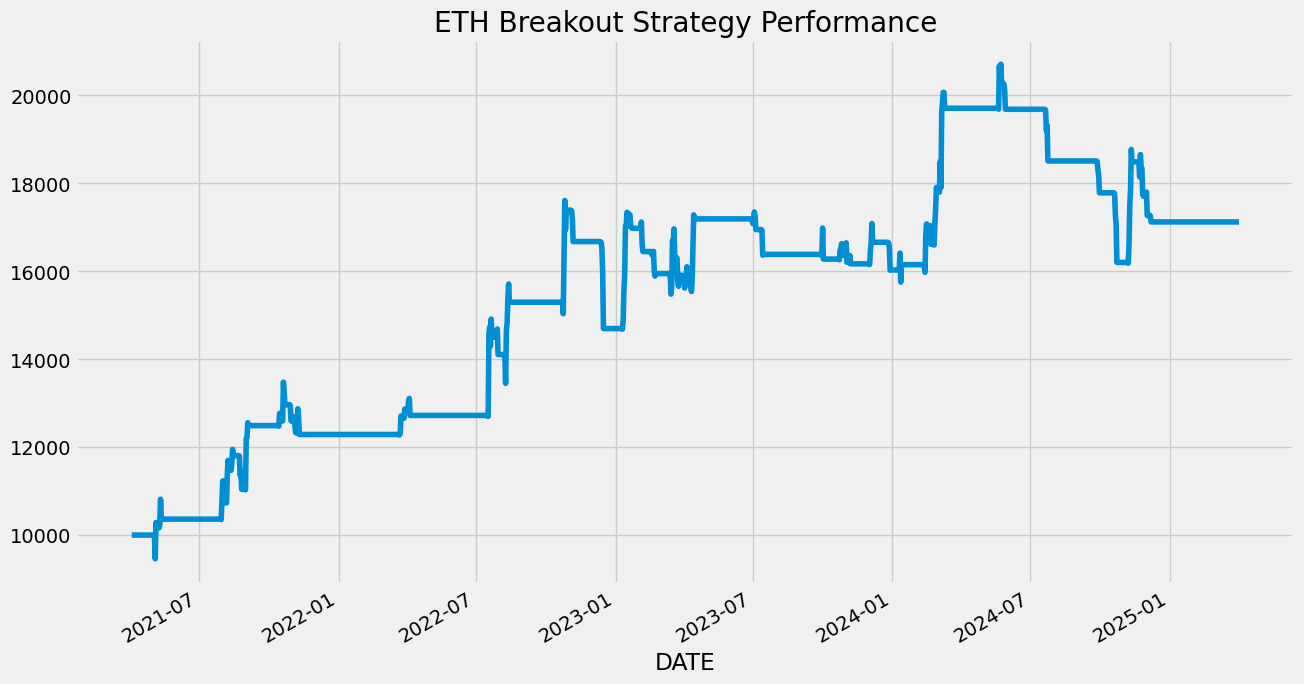

In [6]:
# Run backtest
portfolio = vbt.Portfolio.from_signals(
    close=eth_price,
    entries=entries,
    exits=exits,
    init_cash=10000,  # Starting with $10,000
    fees=0.001  # 0.1% trading fee
)

# Plot portfolio value
portfolio.value().plot(title="ETH Breakout Strategy Performance")

### Step 5: Analyze Performance

In [7]:
# Calculate performance metrics
print(f"Total Return: {portfolio.total_return()*100:.2f}%")
print(f"Max Drawdown: {portfolio.max_drawdown()*100:.2f}%")

# Display detailed trade statistics
portfolio.stats()

Total Return: 71.21%
Max Drawdown: -21.85%


Start                         2021-04-03 00:00:00+00:00
End                           2025-04-02 00:00:00+00:00
Period                                             1511
Start Value                                     10000.0
End Value                                  17121.353025
Total Return [%]                               71.21353
Benchmark Return [%]                          -6.666985
Max Gross Exposure [%]                            100.0
Total Fees Paid                             1666.174353
Max Drawdown [%]                              21.846113
Max Drawdown Duration                             506.0
Total Trades                                         54
Total Closed Trades                                  54
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  44.444444
Best Trade [%]                                17.724277
Worst Trade [%]                              -11

## Strategy 2: Volume Weighted Portfolio

This strategy builds a portfolio of the top 10 tokens by market cap, weighted by their market capitalization.

Fetching daily-ohlcv data: 100%|██████████| 51/51 [00:32<00:00,  1.57chunk/s]


<Axes: xlabel='date'>

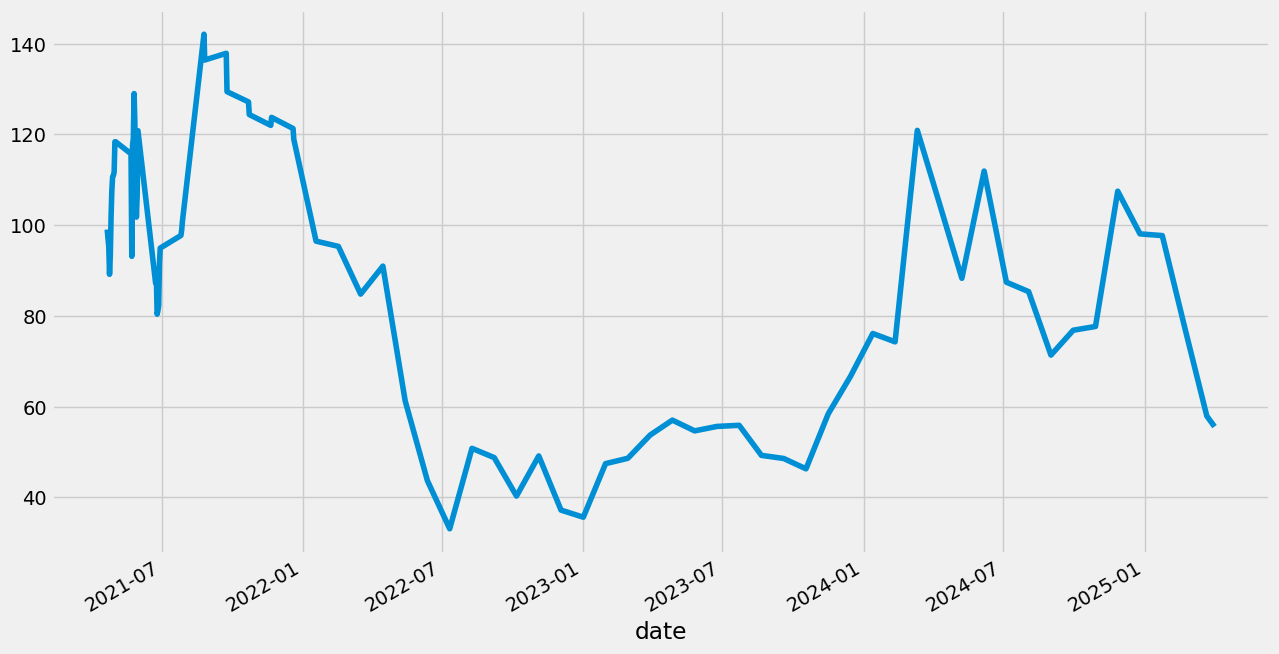

In [8]:
import pickle

# Load Universe
with open('universe.pkl', 'rb') as f:
    universe = pickle.load(f)

# Load OHLCV data
df = client.daily_ohlcv.get_dataframe(
    token_id=', '.join([str(x) for x in universe]),
    startDate=start_date,
    endDate=end_date, 
)

df.columns = df.columns.str.lower()
df.date = pd.to_datetime(df.date)

# Define number of holdings
num_tokens = 10

# Select daily portfolio
daily_portfolio = (df[['date', 'token_id', 'volume', 'close']]
    .sort_values(['date', 'volume'], ascending=[True, False])
    .groupby('date')
    .head(num_tokens)
    .copy()
)

# Compute volume based weights
def calculate_weights(group):
    weights = group['volume'] / group['volume'].sum()
    return weights
    
daily_portfolio['weight'] = daily_portfolio.groupby('date').apply(
    lambda x: calculate_weights(x)
).values

# Unstack weights and prices
weights = (daily_portfolio.set_index(['date', 'token_id'])
        .unstack('token_id').weight
        .groupby(pd.Grouper(freq='D'))
        .ffill()
        .fillna(0))

prices = daily_portfolio.set_index(['date', 'token_id']).unstack('token_id').close

# Remove tokens with zeros in price
zero_columns = weights.columns[weights.eq(0).all()]
clean_weights = weights.drop(columns=zero_columns)
clean_prices = prices.drop(columns=zero_columns)
# forward filling, then backward to avoid missing values - this is automatically handled by Vectorbt Pro
clean_prices = clean_prices.ffill().bfill() 

# Run the portfolio simulation using vectorbt
pf = vbt.Portfolio.from_orders(
    close=clean_prices,
    size=clean_weights,
    size_type='targetpercent',
    init_cash=100, # this is the starting capital
    cash_sharing=True,
    group_by=True,
    call_seq="auto",
    fees=0.01 # 1% per transaction
)

# Plot the portfolio's equity curve
pf.value().plot()

## Strategy 3: Bitcoin Moving Average Crossover

This strategy uses two moving averages (short-term and long-term) to generate buy and sell signals when they cross.

### Step 1: Fetch Bitcoin Price Data

In [9]:
# Calculate date range for the last year
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=365*4)).strftime("%Y-%m-%d")

# Fetch BTC daily OHLCV data
btc_ohlcv_df = client.daily_ohlcv.get_dataframe(
    token_id="3375",  # Bitcoin ID
    startDate=start_date,
    endDate=end_date
)

# Process the data
btc_data = btc_ohlcv_df.copy()
btc_data['DATE'] = pd.to_datetime(btc_data['DATE'])
btc_data = btc_data.sort_values('DATE')

# Extract closing price and set index to timestamp
btc_price = btc_data.set_index('DATE')['CLOSE']

# Display the data
btc_price.head()

Fetching daily-ohlcv data: 100%|██████████| 51/51 [00:27<00:00,  1.87chunk/s]


DATE
2021-04-03 00:00:00+00:00    57612.597843
2021-04-04 00:00:00+00:00    58187.644223
2021-04-05 00:00:00+00:00    59058.613490
2021-04-06 00:00:00+00:00    58025.023923
2021-04-07 00:00:00+00:00    55976.993202
Name: CLOSE, dtype: float64

### Step 2: Calculate Moving Averages and Signals

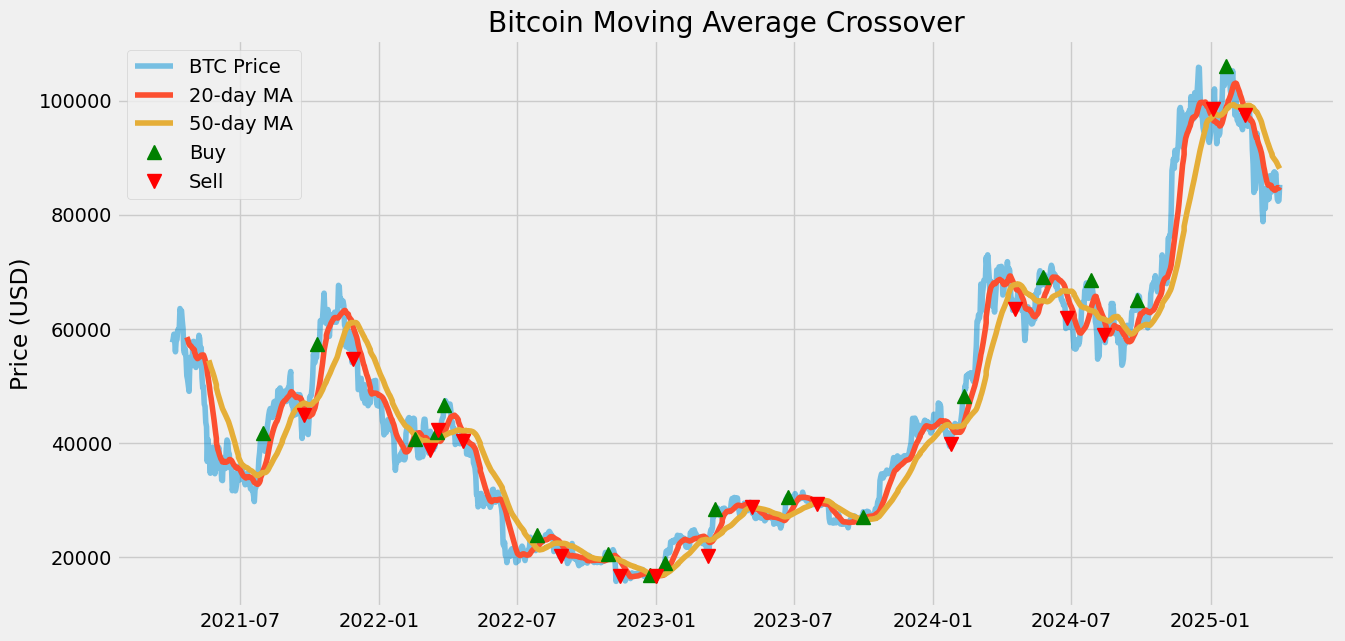

In [10]:
# Define moving average periods
short_window = 20
long_window = 50

# Calculate moving averages
short_ma = btc_price.rolling(window=short_window).mean()
long_ma = btc_price.rolling(window=long_window).mean()

# Create signals DataFrame
signals = pd.DataFrame(index=btc_price.index)
signals['price'] = btc_price
signals['short_ma'] = short_ma
signals['long_ma'] = long_ma

# Generate buy/sell signals
# Buy when short MA crosses above long MA, sell when short MA crosses below long MA
signals['signal'] = 0.0
signals['signal'] = np.where(signals['short_ma'] > signals['long_ma'], 1.0, 0.0)

# Generate trading orders
signals['position'] = signals['signal'].diff()
signals['entry'] = signals['position'] == 1.0
signals['exit'] = signals['position'] == -1.0

# Plot the moving averages and the signals
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(signals['price'], alpha=0.5, label='BTC Price')
ax.plot(signals['short_ma'], label=f'{short_window}-day MA')
ax.plot(signals['long_ma'], label=f'{long_window}-day MA')

# Add buy/sell markers
ax.plot(signals.loc[signals['entry']].index, 
         signals.price[signals['entry']], 
         '^', markersize=10, color='g', label='Buy')
ax.plot(signals.loc[signals['exit']].index, 
         signals.price[signals['exit']], 
         'v', markersize=10, color='r', label='Sell')

ax.set_title('Bitcoin Moving Average Crossover')
ax.set_ylabel('Price (USD)')
ax.legend()
plt.grid(True)
plt.show()

### Step 3: Backtest the Moving Average Crossover Strategy

In [11]:
# Run backtest with VectorBT
ma_portfolio = vbt.Portfolio.from_signals(
    close=signals['price'],
    entries=signals['entry'],
    exits=signals['exit'],
    init_cash=10000,  # Starting with $10,000
    fees=0.001  # 0.1% trading fee
)

# Plot portfolio value
ma_portfolio.plot(title="BTC Moving Average Crossover Strategy Performance")

# Display detailed trade statistics
ma_portfolio.stats()

Start                         2021-04-03 00:00:00+00:00
End                           2025-04-02 00:00:00+00:00
Period                                             1511
Start Value                                     10000.0
End Value                                  12083.370507
Total Return [%]                              20.833705
Benchmark Return [%]                           47.95028
Max Gross Exposure [%]                            100.0
Total Fees Paid                              297.354123
Max Drawdown [%]                              56.932876
Max Drawdown Duration                             882.0
Total Trades                                         17
Total Closed Trades                                  17
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  41.176471
Best Trade [%]                                 51.10992
Worst Trade [%]                              -19

## Strategy 4: Bollinger Band Mean Reversion

This strategy uses Bollinger Bands to identify potential reversions to the mean. It buys when the price touches the lower band and sells when it reaches the middle band (mean).

### Step 1: Fetch and Prepare Data

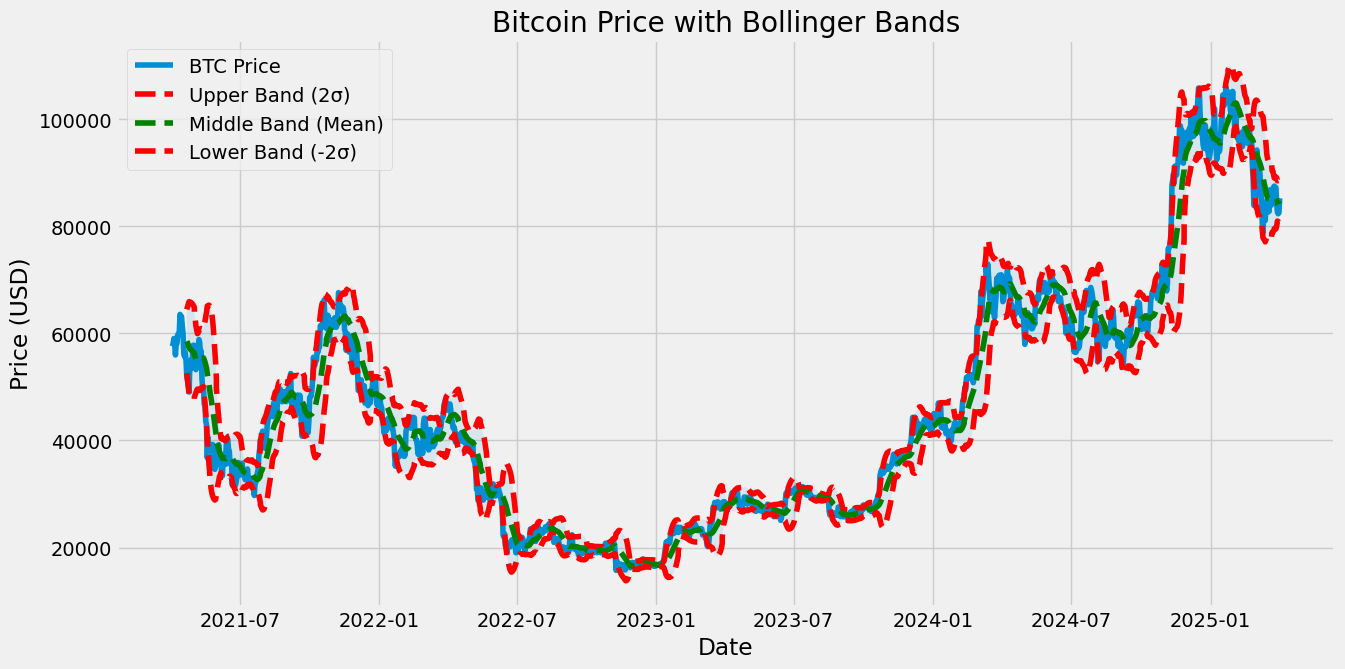

In [12]:
# We'll use the same BTC data we already fetched
# Make sure we have it sorted by date
btc_data = btc_ohlcv_df.copy()
btc_data['DATE'] = pd.to_datetime(btc_data['DATE'])
btc_data = btc_data.sort_values('DATE')

# Set index to date for easier time series manipulation
btc_data = btc_data.set_index('DATE')

# Calculate 20-day rolling mean and standard deviation
window = 20
rolling_mean = btc_data['CLOSE'].rolling(window=window).mean()
rolling_std = btc_data['CLOSE'].rolling(window=window).std()

# Calculate upper and lower Bollinger Bands
btc_data['BB_upper'] = rolling_mean + (rolling_std * 2)
btc_data['BB_middle'] = rolling_mean
btc_data['BB_lower'] = rolling_mean - (rolling_std * 2)

# Plot Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(btc_data.index, btc_data['CLOSE'], label='BTC Price')
plt.plot(btc_data.index, btc_data['BB_upper'], 'r--', label='Upper Band (2σ)')
plt.plot(btc_data.index, btc_data['BB_middle'], 'g--', label='Middle Band (Mean)')
plt.plot(btc_data.index, btc_data['BB_lower'], 'r--', label='Lower Band (-2σ)')
plt.fill_between(btc_data.index, btc_data['BB_upper'], btc_data['BB_lower'], alpha=0.1)
plt.title('Bitcoin Price with Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Step 2: Generate Trading Signals

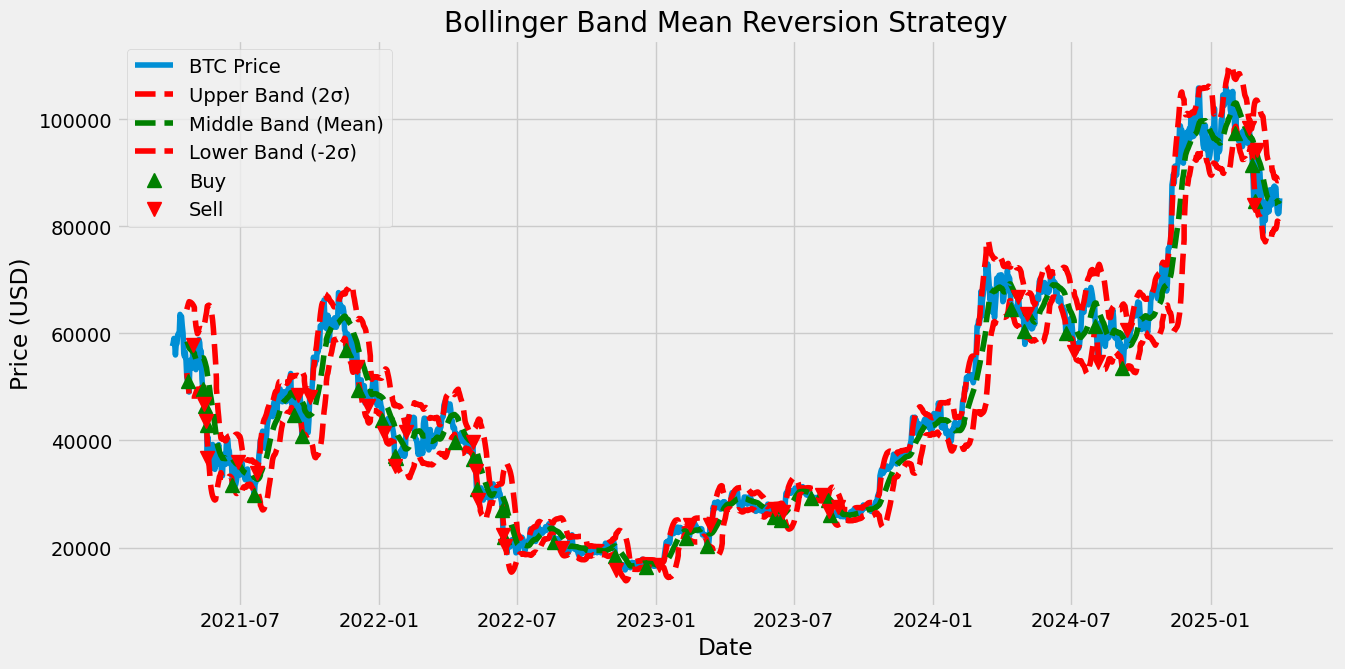

In [13]:
# Define the strategy rules
# Buy when price touches lower band
# Sell when price reaches the middle band or drops 5% below purchase price (stop loss)

# Initialize the signals columns
btc_data['signal'] = 0  # 0: no position, 1: long position
btc_data['entry'] = False
btc_data['exit'] = False

# Forward-looking variable (for calculation purposes only)
btc_data['next_price'] = btc_data['CLOSE'].shift(-1)

# Calculate signals
for i in range(window, len(btc_data)):
    if btc_data['signal'].iloc[i-1] == 0:  # Not in a position
        # Buy condition: price touches lower band
        if btc_data['CLOSE'].iloc[i] <= btc_data['BB_lower'].iloc[i]:
            btc_data['signal'].iloc[i] = 1
            btc_data['entry'].iloc[i] = True
    elif btc_data['signal'].iloc[i-1] == 1:  # Already in a position
        entry_price = btc_data.loc[btc_data['entry'] == True, 'CLOSE'].iloc[-1]
        # Sell conditions:
        # 1. Price reaches middle band (target)
        # 2. Price drops 5% below purchase price (stop-loss)
        if (btc_data['CLOSE'].iloc[i] >= btc_data['BB_middle'].iloc[i] or 
            btc_data['CLOSE'].iloc[i] <= entry_price * 0.95):
            btc_data['signal'].iloc[i] = 0
            btc_data['exit'].iloc[i] = True
        else:
            btc_data['signal'].iloc[i] = 1  # Continue holding

# Plot the signals
plt.figure(figsize=(14, 7))
plt.plot(btc_data.index, btc_data['CLOSE'], label='BTC Price')
plt.plot(btc_data.index, btc_data['BB_upper'], 'r--', label='Upper Band (2σ)')
plt.plot(btc_data.index, btc_data['BB_middle'], 'g--', label='Middle Band (Mean)')
plt.plot(btc_data.index, btc_data['BB_lower'], 'r--', label='Lower Band (-2σ)')

# Add buy/sell markers
plt.plot(btc_data.index[btc_data['entry']], 
         btc_data.loc[btc_data['entry'], 'CLOSE'], 
         '^', markersize=10, color='g', label='Buy')
plt.plot(btc_data.index[btc_data['exit']], 
         btc_data.loc[btc_data['exit'], 'CLOSE'], 
         'v', markersize=10, color='r', label='Sell')

plt.title('Bollinger Band Mean Reversion Strategy')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Step 3: Backtest the Bollinger Band Strategy

In [14]:
# Run backtest with VectorBT
bb_portfolio = vbt.Portfolio.from_signals(
    close=btc_data['CLOSE'],
    entries=btc_data['entry'],
    exits=btc_data['exit'],
    init_cash=10000,  # Starting with $10,000
    fees=0.001  # 0.1% trading fee
)

# Plot portfolio value
bb_portfolio.plot(title="Bollinger Band Mean Reversion Strategy Performance")

# Display detailed trade statistics
bb_portfolio.stats()

Start                         2021-04-03 00:00:00+00:00
End                           2025-04-02 00:00:00+00:00
Period                                             1511
Start Value                                     10000.0
End Value                                   10399.69544
Total Return [%]                               3.996954
Benchmark Return [%]                           47.95028
Max Gross Exposure [%]                            100.0
Total Fees Paid                              731.512798
Max Drawdown [%]                              54.875737
Max Drawdown Duration                            1272.0
Total Trades                                         36
Total Closed Trades                                  36
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                       50.0
Best Trade [%]                                18.388191
Worst Trade [%]                              -17

## Strategy 5: RSI Oscillator Strategy

This strategy uses the Relative Strength Index (RSI) to identify overbought and oversold conditions. It buys when RSI is below 30 (oversold) and sells when RSI is above 70 (overbought).

### Step 1: Calculate RSI

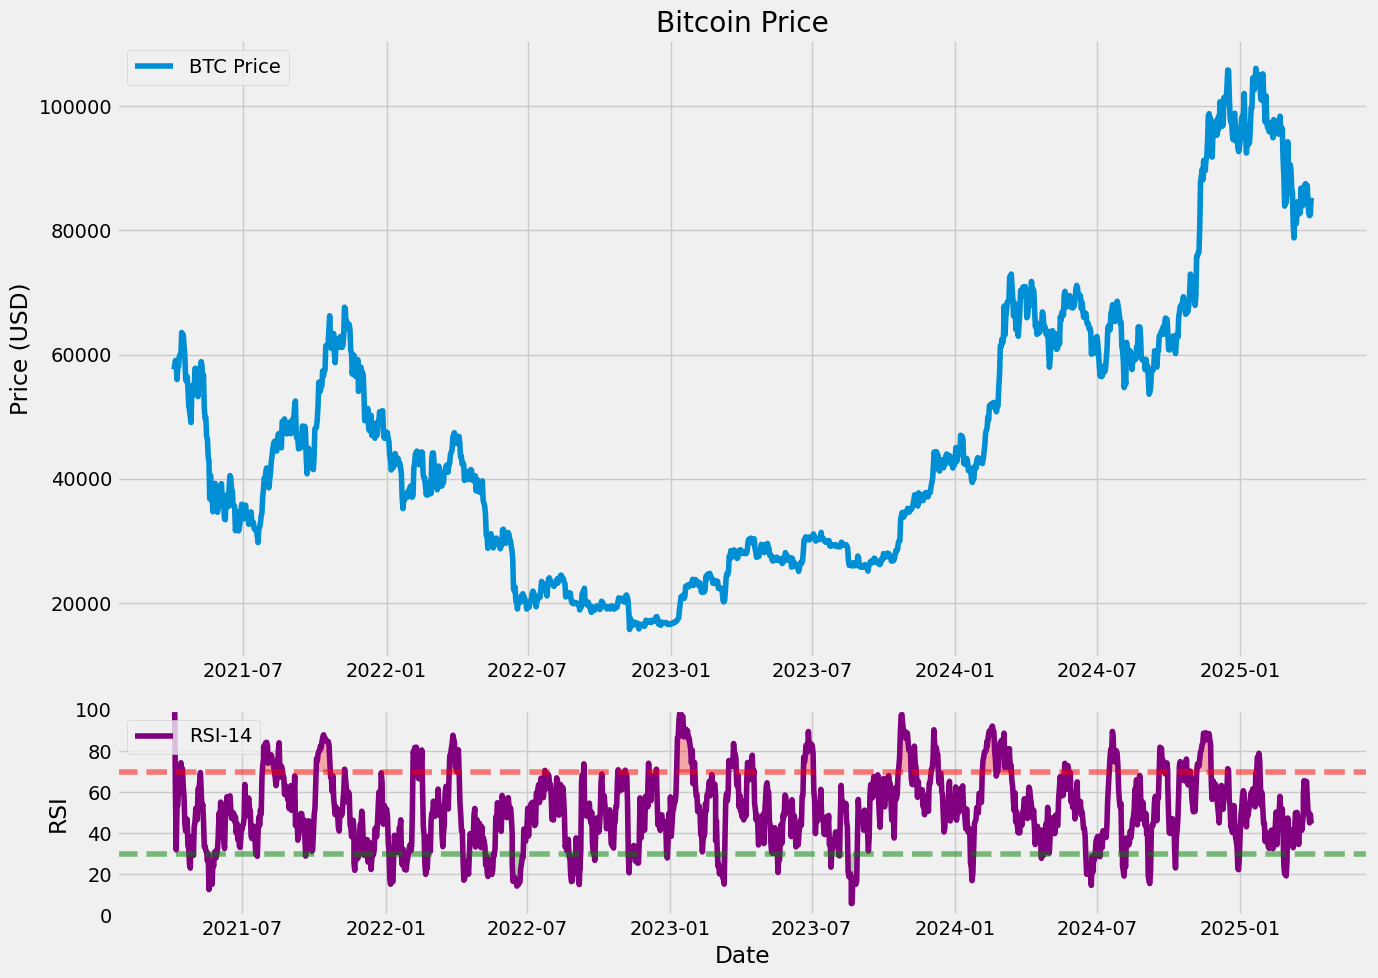

In [15]:
# Function to calculate RSI
def calculate_rsi(data, window=14):
    # Calculate price changes
    delta = data.diff()
    
    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    # Calculate average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    # Calculate relative strength
    rs = avg_gain / avg_loss
    
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Calculate RSI for Bitcoin price
btc_close = btc_data['CLOSE']
rsi_period = 14
btc_data['RSI'] = calculate_rsi(btc_close, window=rsi_period)

# Create a plot with RSI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

# Price chart
ax1.plot(btc_data.index, btc_data['CLOSE'], label='BTC Price')
ax1.set_title('Bitcoin Price')
ax1.set_ylabel('Price (USD)')
ax1.grid(True)
ax1.legend()

# RSI chart
ax2.plot(btc_data.index, btc_data['RSI'], label=f'RSI-{rsi_period}', color='purple')
ax2.axhline(70, linestyle='--', color='r', alpha=0.5)
ax2.axhline(30, linestyle='--', color='g', alpha=0.5)
ax2.fill_between(btc_data.index, btc_data['RSI'], 70, where=(btc_data['RSI'] >= 70), color='r', alpha=0.3)
ax2.fill_between(btc_data.index, btc_data['RSI'], 30, where=(btc_data['RSI'] <= 30), color='g', alpha=0.3)
ax2.set_ylim(0, 100)
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

### Step 2: Generate Trading Signals Based on RSI

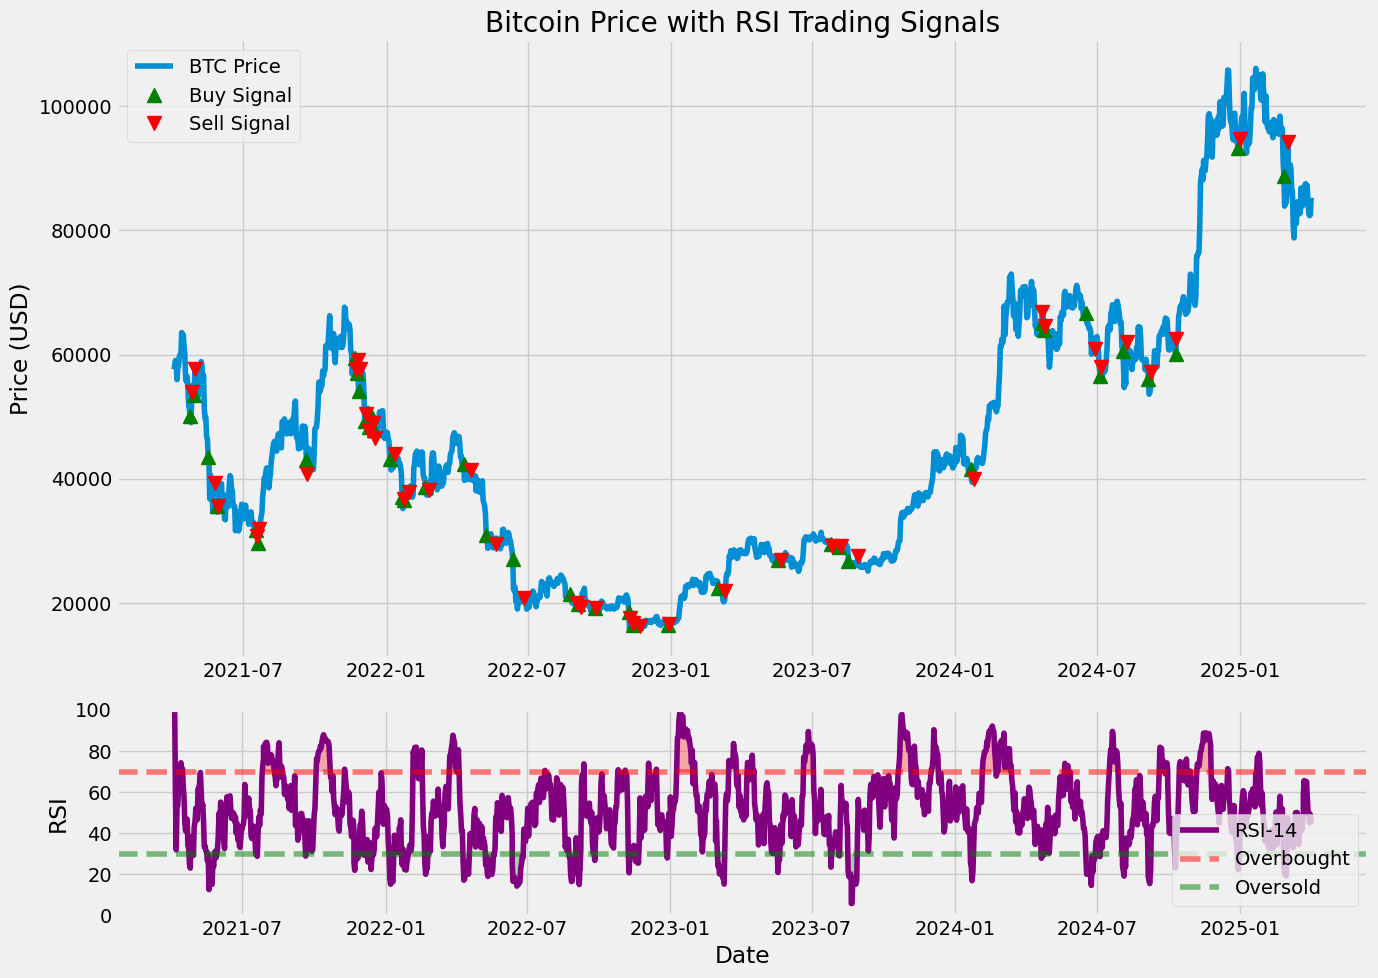

In [16]:
# Define RSI thresholds
oversold_threshold = 30
overbought_threshold = 70

# Create signals DataFrame
rsi_signals = pd.DataFrame(index=btc_data.index)
rsi_signals['price'] = btc_data['CLOSE']
rsi_signals['rsi'] = btc_data['RSI']

# Generate signals
# Buy when RSI crosses below the oversold threshold
# Sell when RSI crosses above the overbought threshold
rsi_signals['position'] = 0  # Initialize position column
rsi_signals['position'] = np.where(rsi_signals['rsi'] < oversold_threshold, 1, 0)  # Long position when oversold
rsi_signals['position'] = np.where(rsi_signals['rsi'] > overbought_threshold, 0, rsi_signals['position'])  # Exit when overbought

# Generate entry and exit signals for backtesting
rsi_signals['entry'] = rsi_signals['position'].diff() > 0
rsi_signals['exit'] = rsi_signals['position'].diff() < 0

# Create combined price and RSI plot with signals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

# Price chart with buy/sell signals
ax1.plot(rsi_signals.index, rsi_signals['price'], label='BTC Price')
ax1.plot(rsi_signals.loc[rsi_signals['entry']].index, 
         rsi_signals.loc[rsi_signals['entry'], 'price'], 
         '^', markersize=10, color='g', label='Buy Signal')
ax1.plot(rsi_signals.loc[rsi_signals['exit']].index, 
         rsi_signals.loc[rsi_signals['exit'], 'price'], 
         'v', markersize=10, color='r', label='Sell Signal')
ax1.set_title('Bitcoin Price with RSI Trading Signals')
ax1.set_ylabel('Price (USD)')
ax1.grid(True)
ax1.legend()

# RSI chart
ax2.plot(rsi_signals.index, rsi_signals['rsi'], label=f'RSI-{rsi_period}', color='purple')
ax2.axhline(overbought_threshold, linestyle='--', color='r', alpha=0.5, label='Overbought')
ax2.axhline(oversold_threshold, linestyle='--', color='g', alpha=0.5, label='Oversold')
ax2.fill_between(rsi_signals.index, rsi_signals['rsi'], overbought_threshold, 
                 where=(rsi_signals['rsi'] >= overbought_threshold), color='r', alpha=0.3)
ax2.fill_between(rsi_signals.index, rsi_signals['rsi'], oversold_threshold, 
                 where=(rsi_signals['rsi'] <= oversold_threshold), color='g', alpha=0.3)
ax2.set_ylim(0, 100)
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

### Step 3: Backtest the RSI Strategy

In [17]:
# Run backtest with VectorBT
rsi_portfolio = vbt.Portfolio.from_signals(
    close=rsi_signals['price'],
    entries=rsi_signals['entry'],
    exits=rsi_signals['exit'],
    init_cash=10000,  # Starting with $10,000
    fees=0.001  # 0.1% trading fee
)

# Plot portfolio value
rsi_portfolio.plot(title="RSI Strategy Performance")

# Display detailed trade statistics
rsi_portfolio.stats()

Start                         2021-04-03 00:00:00+00:00
End                           2025-04-02 00:00:00+00:00
Period                                             1511
Start Value                                     10000.0
End Value                                    6769.43916
Total Return [%]                             -32.305608
Benchmark Return [%]                           47.95028
Max Gross Exposure [%]                            100.0
Total Fees Paid                              717.446248
Max Drawdown [%]                              54.452285
Max Drawdown Duration                            1466.0
Total Trades                                         43
Total Closed Trades                                  43
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  46.511628
Best Trade [%]                                 7.608123
Worst Trade [%]                              -23

## Strategy 6: Volume Weighted Moving Average (VWMA) Strategy

This strategy uses volume to give more weight to price movements with higher trading volume. It generates buy signals when price crosses above the VWMA and sell signals when it crosses below.

### Step 1: Fetch BTC Data and Calculate VWMA

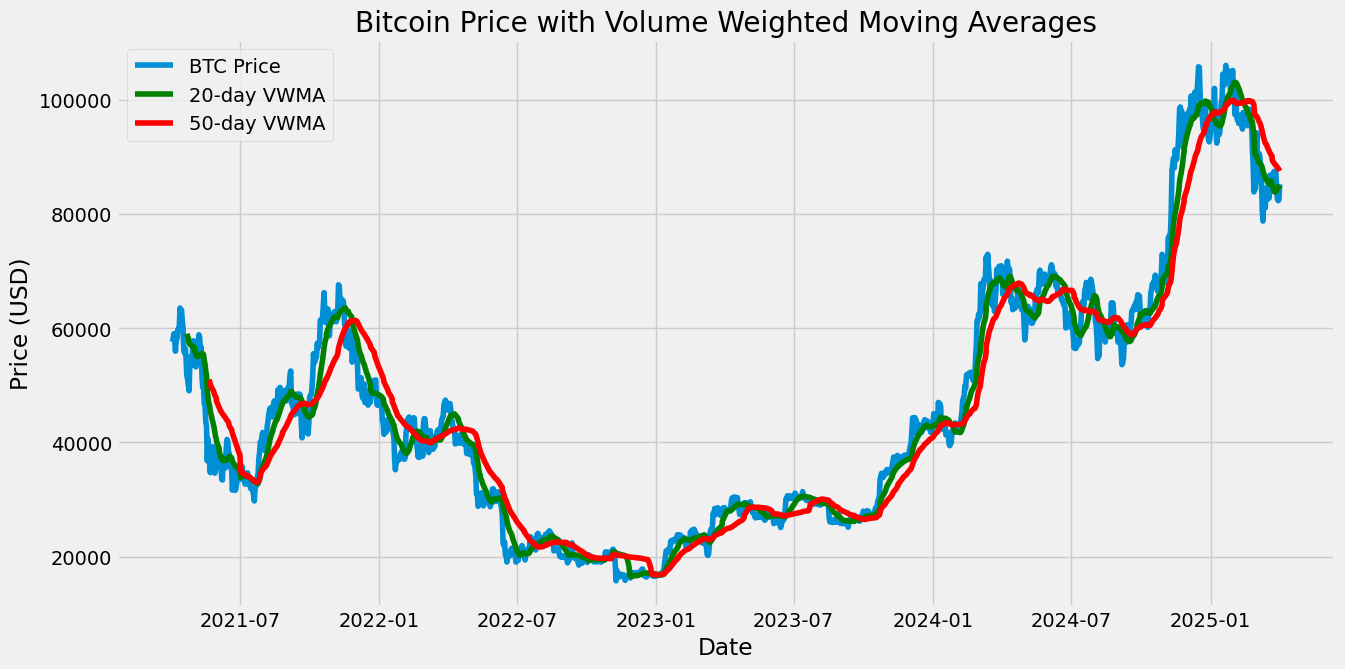

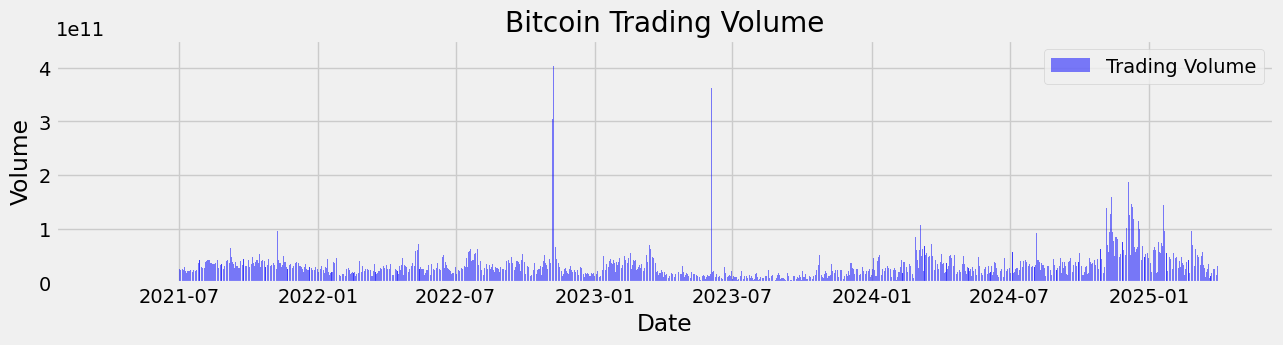

In [18]:
# Function to calculate Volume Weighted Moving Average (VWMA)
def calculate_vwma(price, volume, window):
    """Calculate Volume Weighted Moving Average"""
    price_volume = price * volume
    return price_volume.rolling(window=window).sum() / volume.rolling(window=window).sum()

# We'll use our existing btc_data DataFrame
# Make sure the column names are consistent
btc_vwma_data = btc_data.copy()

# Calculate VWMA for different periods
short_window = 20
long_window = 50
btc_vwma_data['VWMA_short'] = calculate_vwma(btc_vwma_data['CLOSE'], btc_vwma_data['VOLUME'], short_window)
btc_vwma_data['VWMA_long'] = calculate_vwma(btc_vwma_data['CLOSE'], btc_vwma_data['VOLUME'], long_window)

# Plot price and VWMAs
plt.figure(figsize=(14, 7))
plt.plot(btc_vwma_data.index, btc_vwma_data['CLOSE'], label='BTC Price')
plt.plot(btc_vwma_data.index, btc_vwma_data['VWMA_short'], label=f'{short_window}-day VWMA', color='green')
plt.plot(btc_vwma_data.index, btc_vwma_data['VWMA_long'], label=f'{long_window}-day VWMA', color='red')
plt.title('Bitcoin Price with Volume Weighted Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the volume separately
plt.figure(figsize=(14, 3))
plt.bar(btc_vwma_data.index, btc_vwma_data['VOLUME'], color='blue', alpha=0.5, label='Trading Volume')
plt.title('Bitcoin Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

### Step 2: Generate Trading Signals Based on VWMA Crossover

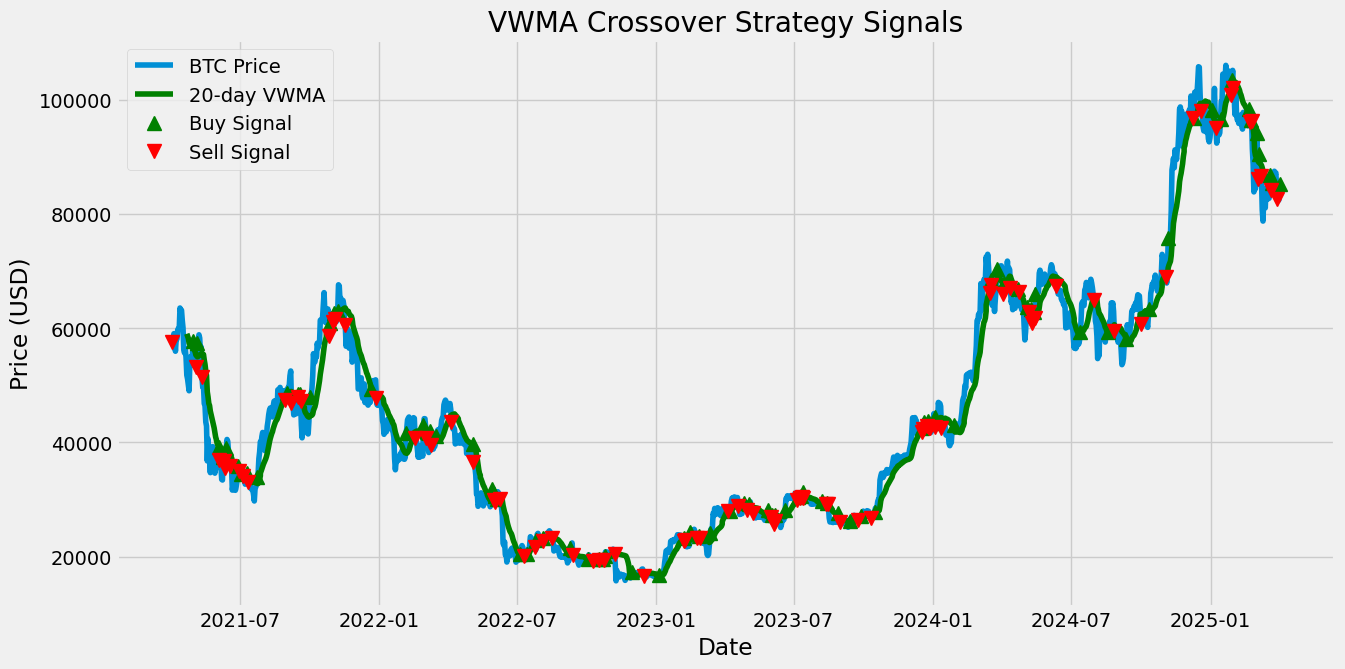

In [19]:
# Generate signals based on VWMA crossover
btc_vwma_data['signal'] = 0

# Generate buy signals when price crosses above short VWMA
btc_vwma_data['signal'] = np.where(
    (btc_vwma_data['CLOSE'] > btc_vwma_data['VWMA_short']) & 
    (btc_vwma_data['CLOSE'].shift(1) <= btc_vwma_data['VWMA_short'].shift(1)), 
    1, 
    btc_vwma_data['signal']
)

# Generate sell signals when price crosses below short VWMA
btc_vwma_data['signal'] = np.where(
    (btc_vwma_data['CLOSE'] < btc_vwma_data['VWMA_short']) & 
    (btc_vwma_data['CLOSE'].shift(1) >= btc_vwma_data['VWMA_short'].shift(1)), 
    -1, 
    btc_vwma_data['signal']
)

# Create position column (1: long, 0: out of market)
btc_vwma_data['position'] = 0
current_position = 0

# Calculate positions (state of being in the market)
for i in range(len(btc_vwma_data)):
    if btc_vwma_data['signal'].iloc[i] == 1:  # Buy signal
        current_position = 1
    elif btc_vwma_data['signal'].iloc[i] == -1:  # Sell signal
        current_position = 0
    
    btc_vwma_data['position'].iloc[i] = current_position

# Generate entries and exits for VectorBT
btc_vwma_data['entry'] = (btc_vwma_data['position'] == 1) & (btc_vwma_data['position'].shift(1) != 1)
btc_vwma_data['exit'] = (btc_vwma_data['position'] == 0) & (btc_vwma_data['position'].shift(1) != 0)

# Plot the signals
plt.figure(figsize=(14, 7))
plt.plot(btc_vwma_data.index, btc_vwma_data['CLOSE'], label='BTC Price')
plt.plot(btc_vwma_data.index, btc_vwma_data['VWMA_short'], label=f'{short_window}-day VWMA', color='green')

# Add buy/sell markers
plt.plot(btc_vwma_data.loc[btc_vwma_data['entry']].index, 
         btc_vwma_data.loc[btc_vwma_data['entry'], 'CLOSE'], 
         '^', markersize=10, color='g', label='Buy Signal')
plt.plot(btc_vwma_data.loc[btc_vwma_data['exit']].index, 
         btc_vwma_data.loc[btc_vwma_data['exit'], 'CLOSE'], 
         'v', markersize=10, color='r', label='Sell Signal')

plt.title('VWMA Crossover Strategy Signals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Step 3: Backtest the VWMA Strategy

In [20]:
# Run backtest with VectorBT
vwma_portfolio = vbt.Portfolio.from_signals(
    close=btc_vwma_data['CLOSE'],
    entries=btc_vwma_data['entry'],
    exits=btc_vwma_data['exit'],
    init_cash=10000,  # Starting with $10,000
    fees=0.001  # 0.1% trading fee
)

# Plot portfolio value
vwma_portfolio.plot(title="VWMA Strategy Performance")

# Display detailed trade statistics
vwma_portfolio.stats()

Start                         2021-04-03 00:00:00+00:00
End                           2025-04-02 00:00:00+00:00
Period                                             1511
Start Value                                     10000.0
End Value                                  13102.888869
Total Return [%]                              31.028889
Benchmark Return [%]                           47.95028
Max Gross Exposure [%]                            100.0
Total Fees Paid                             1596.159988
Max Drawdown [%]                               45.09931
Max Drawdown Duration                             890.0
Total Trades                                         88
Total Closed Trades                                  87
Total Open Trades                                     1
Open Trade PnL                               -13.102889
Win Rate [%]                                  24.137931
Best Trade [%]                                53.283854
Worst Trade [%]                              -10

## Strategy 7: MACD Trend Following Strategy

This strategy uses the Moving Average Convergence Divergence (MACD) indicator to identify trend changes. It generates buy signals when the MACD line crosses above the signal line and sell signals when it crosses below.

### Step 1: Calculate MACD Indicator

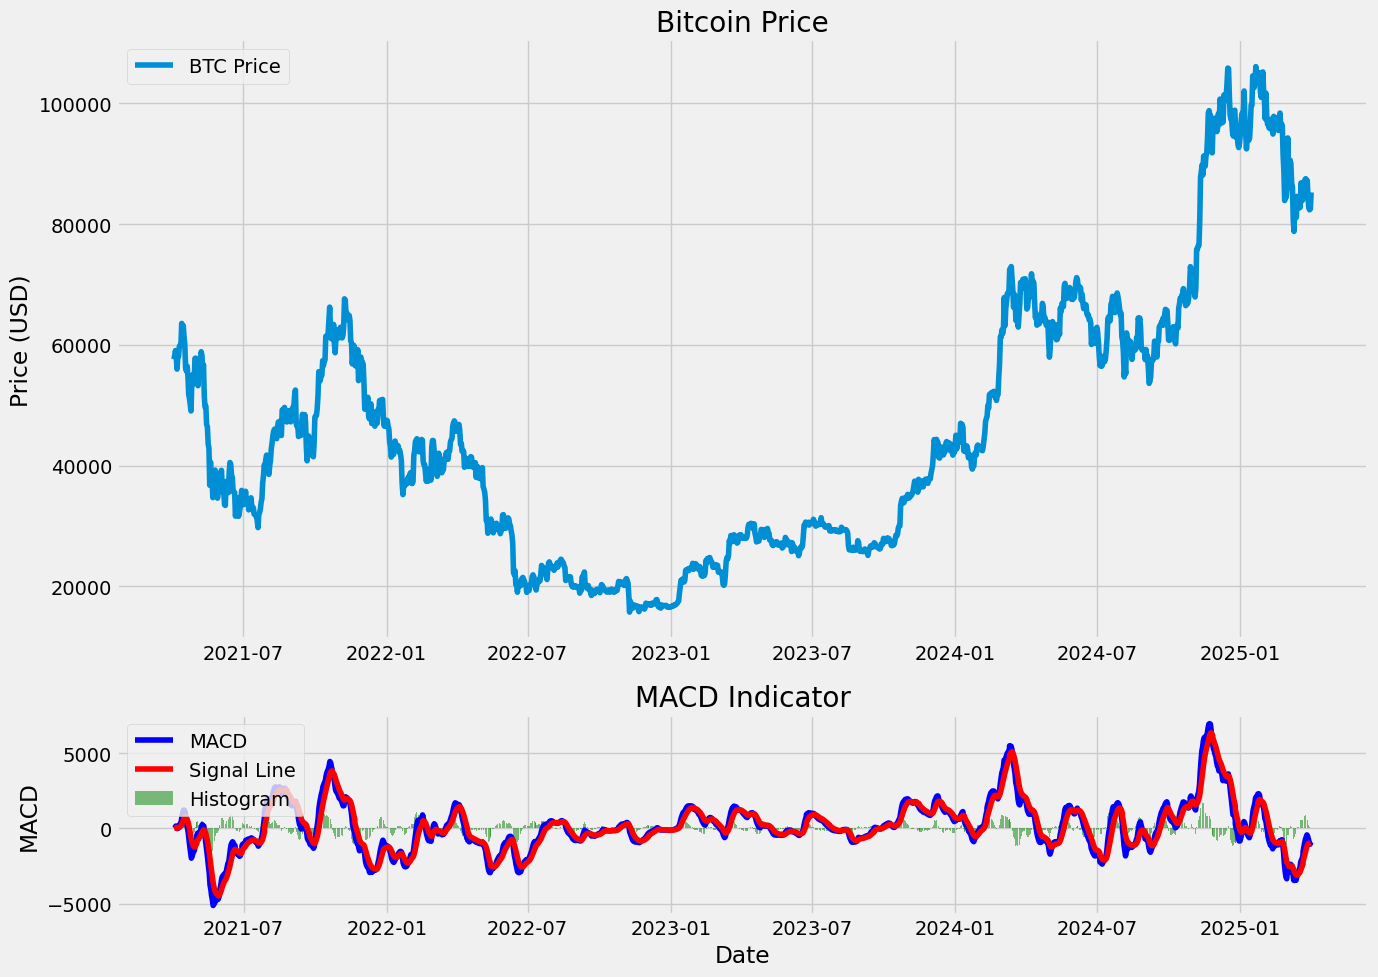

In [21]:
# Function to calculate MACD
def calculate_macd(price, fast_period=12, slow_period=26, signal_period=9):
    """Calculate MACD (Moving Average Convergence/Divergence)"""
    # Calculate the fast and slow EMAs
    fast_ema = price.ewm(span=fast_period, adjust=False).mean()
    slow_ema = price.ewm(span=slow_period, adjust=False).mean()
    
    # Calculate MACD line
    macd_line = fast_ema - slow_ema
    
    # Calculate the signal line
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    
    # Calculate the histogram
    histogram = macd_line - signal_line
    
    return macd_line, signal_line, histogram

# Calculate MACD for Bitcoin
btc_macd_data = btc_data.copy()
macd_line, signal_line, histogram = calculate_macd(btc_macd_data['CLOSE'])

# Add MACD components to DataFrame
btc_macd_data['MACD'] = macd_line
btc_macd_data['Signal'] = signal_line
btc_macd_data['Histogram'] = histogram

# Create a plot with MACD
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

# Price chart
ax1.plot(btc_macd_data.index, btc_macd_data['CLOSE'], label='BTC Price')
ax1.set_title('Bitcoin Price')
ax1.set_ylabel('Price (USD)')
ax1.grid(True)
ax1.legend()

# MACD chart
ax2.plot(btc_macd_data.index, btc_macd_data['MACD'], label='MACD', color='blue')
ax2.plot(btc_macd_data.index, btc_macd_data['Signal'], label='Signal Line', color='red')
# Plot histogram as bar chart
ax2.bar(btc_macd_data.index, btc_macd_data['Histogram'], label='Histogram', color='green', alpha=0.5)
ax2.set_title('MACD Indicator')
ax2.set_xlabel('Date')
ax2.set_ylabel('MACD')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

### Step 2: Generate Trading Signals Based on MACD Crossover

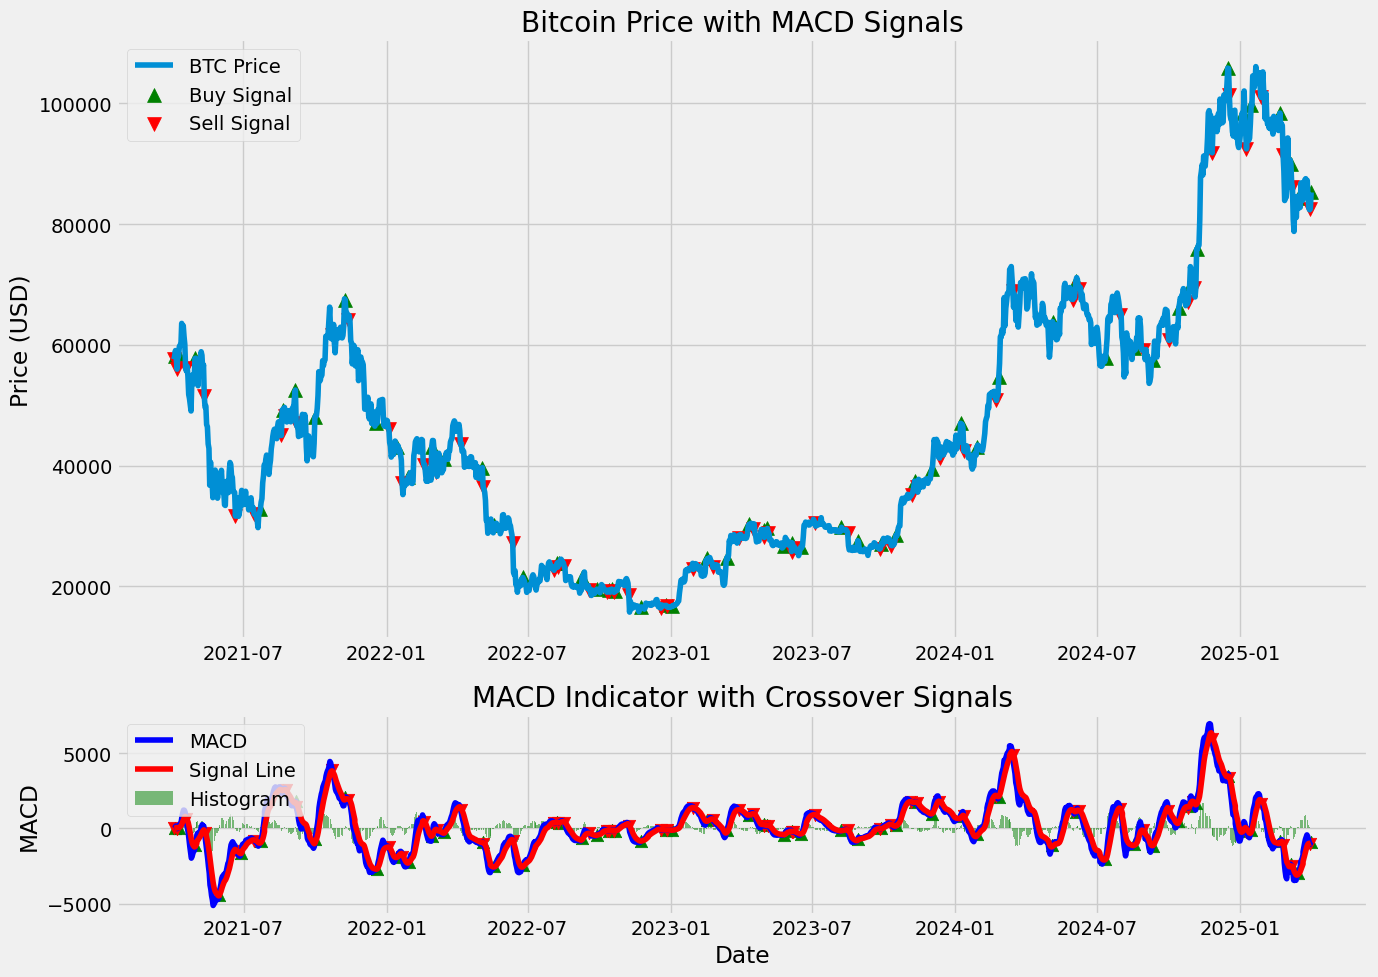

In [22]:
# Generate MACD signals
# Buy when MACD crosses above signal line (bullish)
# Sell when MACD crosses below signal line (bearish)
btc_macd_data['signal'] = 0
btc_macd_data['position'] = 0

# Generate crossover signals
btc_macd_data['signal'] = np.select(
    [
        # Bullish crossover
        (btc_macd_data['MACD'] > btc_macd_data['Signal']) & 
        (btc_macd_data['MACD'].shift() <= btc_macd_data['Signal'].shift()),
        
        # Bearish crossover
        (btc_macd_data['MACD'] < btc_macd_data['Signal']) & 
        (btc_macd_data['MACD'].shift() >= btc_macd_data['Signal'].shift())
    ],
    [1, -1],
    default=0
)

# Calculate positions
btc_macd_data['position'] = 0
current_position = 0
for i in range(len(btc_macd_data)):
    if btc_macd_data['signal'].iloc[i] == 1:  # Buy signal
        current_position = 1
    elif btc_macd_data['signal'].iloc[i] == -1:  # Sell signal
        current_position = 0
    
    btc_macd_data.loc[btc_macd_data.index[i], 'position'] = current_position

# Generate entries and exits for VectorBT
btc_macd_data['entry'] = (btc_macd_data['position'] == 1) & (btc_macd_data['position'].shift(1) != 1)
btc_macd_data['exit'] = (btc_macd_data['position'] == 0) & (btc_macd_data['position'].shift(1) != 0)

# Create a plot with MACD and signals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

# Price chart with buy/sell signals
ax1.plot(btc_macd_data.index, btc_macd_data['CLOSE'], label='BTC Price')
buy_signals = btc_macd_data[btc_macd_data['entry']]
sell_signals = btc_macd_data[btc_macd_data['exit']]

if not buy_signals.empty:
    ax1.scatter(buy_signals.index, buy_signals['CLOSE'], 
               marker='^', s=100, color='g', label='Buy Signal')
if not sell_signals.empty:
    ax1.scatter(sell_signals.index, sell_signals['CLOSE'], 
               marker='v', s=100, color='r', label='Sell Signal')

ax1.set_title('Bitcoin Price with MACD Signals')
ax1.set_ylabel('Price (USD)')
ax1.grid(True)
ax1.legend()

# MACD chart
ax2.plot(btc_macd_data.index, btc_macd_data['MACD'], label='MACD', color='blue')
ax2.plot(btc_macd_data.index, btc_macd_data['Signal'], label='Signal Line', color='red')
ax2.bar(btc_macd_data.index, btc_macd_data['Histogram'], label='Histogram', color='green', alpha=0.5)

# Highlight buy/sell signals on MACD
if not buy_signals.empty:
    ax2.scatter(buy_signals.index, buy_signals['MACD'], 
               marker='^', s=80, color='g')
if not sell_signals.empty:
    ax2.scatter(sell_signals.index, sell_signals['MACD'], 
               marker='v', s=80, color='r')

ax2.set_title('MACD Indicator with Crossover Signals')
ax2.set_xlabel('Date')
ax2.set_ylabel('MACD')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

### Step 3: Backtest the MACD Strategy

In [23]:
# Run backtest with VectorBT
macd_portfolio = vbt.Portfolio.from_signals(
    close=btc_macd_data['CLOSE'],
    entries=btc_macd_data['entry'],
    exits=btc_macd_data['exit'],
    init_cash=10000,  # Starting with $10,000
    fees=0.001  # 0.1% trading fee
)

# Plot portfolio value
macd_portfolio.plot(title="MACD Strategy Performance")
# Display detailed trade statistics
macd_portfolio.stats()

Start                         2021-04-03 00:00:00+00:00
End                           2025-04-02 00:00:00+00:00
Period                                             1511
Start Value                                     10000.0
End Value                                  12332.194929
Total Return [%]                              23.321949
Benchmark Return [%]                           47.95028
Max Gross Exposure [%]                            100.0
Total Fees Paid                             1034.694796
Max Drawdown [%]                              52.304992
Max Drawdown Duration                             902.0
Total Trades                                         60
Total Closed Trades                                  59
Total Open Trades                                     1
Open Trade PnL                               -12.332195
Win Rate [%]                                  30.508475
Best Trade [%]                                36.991122
Worst Trade [%]                              -15

## Comparing All Strategies

Let's compare the performance of all the strategies we've implemented.

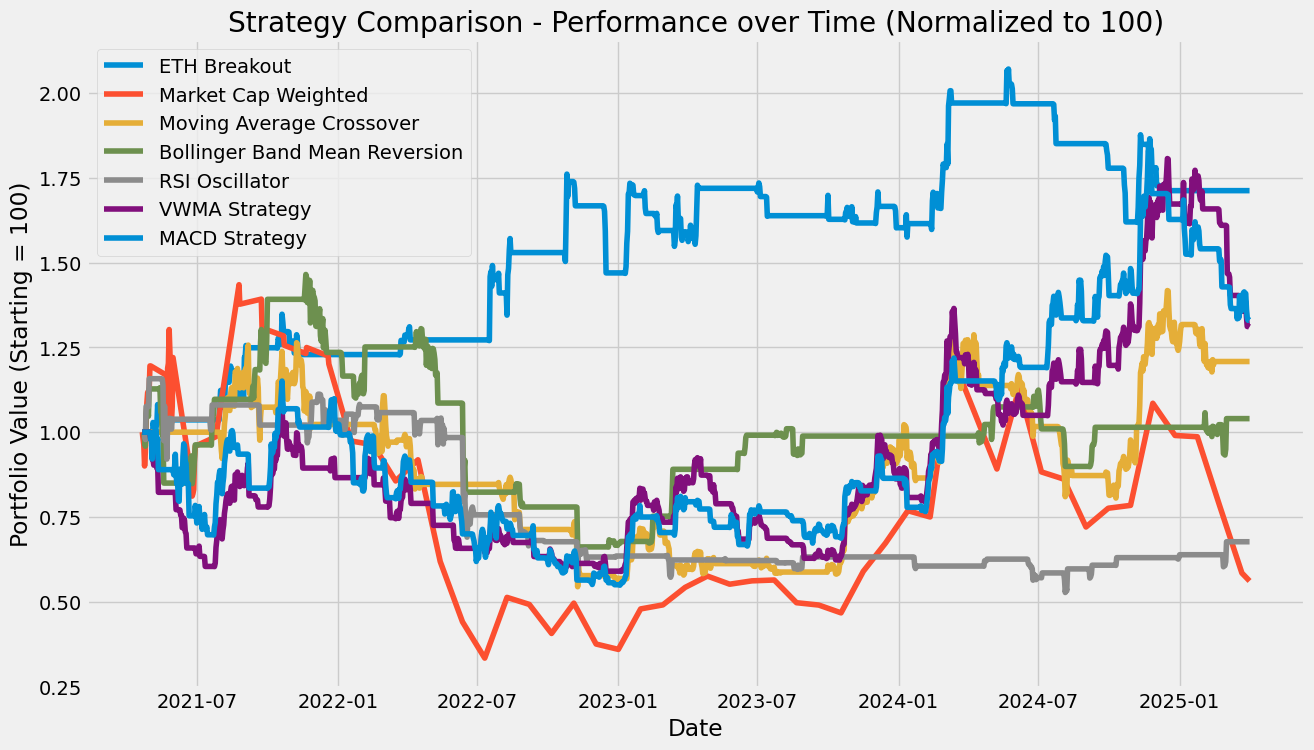

Error in comparison: Index frequency is None. Pass it as `freq` or define it globally under `settings.array_wrapper`.
Note: Some strategies may need to be run first.


In [24]:
# Collect portfolio values for comparison
# Normalize all to 100 for easier comparison
try:
    # Strategy 1: ETH Breakout
    eth_value = portfolio.value() / 10000 * 100
    
    # Strategy 2: Market Cap Weighted
    mcap_value = pf.value() / 100 * 100
    
    # Strategy 3: Moving Average Crossover
    ma_value = ma_portfolio.value() / 10000 * 100
    
    # Strategy 4: Bollinger Band Mean Reversion
    bb_value = bb_portfolio.value() / 10000 * 100
    
    # Strategy 5: RSI Oscillator
    rsi_value = rsi_portfolio.value() / 10000 * 100
    
    # Strategy 6: VWMA Strategy
    vwma_value = vwma_portfolio.value() / 10000 * 100
    
    # Strategy 7: MACD Strategy
    macd_value = macd_portfolio.value() / 10000 * 100
    
    # Create a common date range (the shortest period among all strategies)
    min_date = max(
        eth_value.index.min(),
        mcap_value.index.min(),
        ma_value.index.min(),
        bb_value.index.min(),
        rsi_value.index.min(),
        vwma_value.index.min(),
        macd_value.index.min()
    )
    
    max_date = min(
        eth_value.index.max(),
        mcap_value.index.max(),
        ma_value.index.max(),
        bb_value.index.max(),
        rsi_value.index.max(),
        vwma_value.index.max(),
        macd_value.index.max()
    )
    
    # Filter for the common date range
    eth_value = eth_value.loc[(eth_value.index >= min_date) & (eth_value.index <= max_date)]
    mcap_value = mcap_value.loc[(mcap_value.index >= min_date) & (mcap_value.index <= max_date)]
    ma_value = ma_value.loc[(ma_value.index >= min_date) & (ma_value.index <= max_date)]
    bb_value = bb_value.loc[(bb_value.index >= min_date) & (bb_value.index <= max_date)]
    rsi_value = rsi_value.loc[(rsi_value.index >= min_date) & (rsi_value.index <= max_date)]
    vwma_value = vwma_value.loc[(vwma_value.index >= min_date) & (vwma_value.index <= max_date)]
    macd_value = macd_value.loc[(macd_value.index >= min_date) & (macd_value.index <= max_date)]
    
    # Plot all strategies
    plt.figure(figsize=(14, 8))
    plt.plot(eth_value.index, eth_value / eth_value.iloc[0], label="ETH Breakout")
    plt.plot(mcap_value.index, mcap_value / mcap_value.iloc[0], label="Market Cap Weighted")
    plt.plot(ma_value.index, ma_value / ma_value.iloc[0], label="Moving Average Crossover")
    plt.plot(bb_value.index, bb_value / bb_value.iloc[0], label="Bollinger Band Mean Reversion")
    plt.plot(rsi_value.index, rsi_value / rsi_value.iloc[0], label="RSI Oscillator")
    plt.plot(vwma_value.index, vwma_value / vwma_value.iloc[0], label="VWMA Strategy")
    plt.plot(macd_value.index, macd_value / macd_value.iloc[0], label="MACD Strategy")
    plt.title("Strategy Comparison - Performance over Time (Normalized to 100)")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (Starting = 100)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Create a comparison table of key metrics
    metrics = pd.DataFrame({
        'ETH Breakout': [
            f"{portfolio.total_return()*100:.2f}%",
            f"{portfolio.sharpe_ratio():.2f}",
            f"{portfolio.max_drawdown()*100:.2f}%",
            portfolio.count_trades(),
            f"{portfolio.win_rate()*100:.2f}%"
        ],
        'Market Cap Weighted': [
            f"{pf.total_return()*100:.2f}%",
            f"{pf.sharpe_ratio():.2f}",
            f"{pf.max_drawdown()*100:.2f}%",
            "Rebalancing",
            "N/A"
        ],
        'Moving Average': [
            f"{ma_portfolio.total_return()*100:.2f}%",
            f"{ma_portfolio.sharpe_ratio():.2f}",
            f"{ma_portfolio.max_drawdown()*100:.2f}%",
            ma_portfolio.count_trades(),
            f"{ma_portfolio.win_rate()*100:.2f}%"
        ],
        'Bollinger Bands': [
            f"{bb_portfolio.total_return()*100:.2f}%",
            f"{bb_portfolio.sharpe_ratio():.2f}",
            f"{bb_portfolio.max_drawdown()*100:.2f}%",
            bb_portfolio.count_trades(),
            f"{bb_portfolio.win_rate()*100:.2f}%"
        ],
        'RSI': [
            f"{rsi_portfolio.total_return()*100:.2f}%",
            f"{rsi_portfolio.sharpe_ratio():.2f}",
            f"{rsi_portfolio.max_drawdown()*100:.2f}%",
            rsi_portfolio.count_trades(),
            f"{rsi_portfolio.win_rate()*100:.2f}%"
        ],
        'VWMA': [
            f"{vwma_portfolio.total_return()*100:.2f}%",
            f"{vwma_portfolio.sharpe_ratio():.2f}",
            f"{vwma_portfolio.max_drawdown()*100:.2f}%",
            vwma_portfolio.count_trades(),
            f"{vwma_portfolio.win_rate()*100:.2f}%"
        ],
        'MACD': [
            f"{macd_portfolio.total_return()*100:.2f}%",
            f"{macd_portfolio.sharpe_ratio():.2f}",
            f"{macd_portfolio.max_drawdown()*100:.2f}%",
            macd_portfolio.count_trades(),
            f"{macd_portfolio.win_rate()*100:.2f}%"
        ]
    }, index=['Total Return', 'Sharpe Ratio', 'Max Drawdown', 'Trade Count', 'Win Rate'])
    
    # Display the comparison metrics
    metrics
except Exception as e:
    print(f"Error in comparison: {e}")
    print("Note: Some strategies may need to be run first.")

## Conclusion

In this notebook, we've implemented and compared seven different trading strategies using data from the Token Metrics AI API:

1. **ETH Breakout Strategy**: A momentum strategy that buys ETH when it breaks above its 30-day high.
2. **Volume Weighted Portfolio**: A strategy that builds a portfolio weighted by market capitalization.
3. **Moving Average Crossover Strategy**: A trend-following strategy using two moving averages.
4. **Bollinger Band Mean Reversion Strategy**: A strategy that buys when price hits lower band and sells at mean.
5. **RSI Oscillator Strategy**: A strategy using the Relative Strength Index to identify overbought/oversold conditions.
6. **VWMA (Volume Weighted Moving Average) Strategy**: A strategy that uses volume to weight price movements.
7. **MACD Trend Following Strategy**: A strategy based on the Moving Average Convergence Divergence indicator.

These strategies demonstrate various ways to use the Token Metrics AI API data for algorithmic trading and portfolio management. The implementation can be extended to incorporate other data points provided by the API, such as trader grades, investor grades, or trading signals.

Remember that past performance is not indicative of future results, and all trading strategies should be thoroughly tested and risk-managed before real-world implementation.